## Installing the simpletransformers library

In [1]:
pip install simpletransformers

     |████████████████████████████████| 248 kB 8.0 MB/s 
     |████████████████████████████████| 311 kB 52.8 MB/s 
     |████████████████████████████████| 1.2 MB 56.3 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 3.4 MB 46.8 MB/s 
     |████████████████████████████████| 1.7 MB 63.5 MB/s 
     |████████████████████████████████| 9.3 MB 58.3 MB/s 
     |████████████████████████████████| 6.8 MB 24.2 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 75.2 MB/s 
     |████████████████████████████████| 895 kB 59.7 MB/s 
     |████████████████████████████████| 3.3 MB 72.8 MB/s 
     |████████████████████████████████| 97 kB 8.5 MB/s 
     |████████████████████████████████| 142 kB 68.1 MB/s 
     |████████████████████████████████| 180 kB 82.2 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 133 kB 66.4 MB/s 
     |█████████████████

## Importing neccessary libraries

In [2]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Importing the dataset

In [3]:
train_df = pd.read_csv('statement1.csv' )
train_df.head()

,statement,class
0,This CREDIT AGREEMENT is entered into as of No...,preamble
1,This agreement is dated 22 December 2014 and m...,preamble
2,This Agreement and shall be governed by and in...,governing law
3,The choice of South African law as the governi...,governing law
4,This agreement and other loan documents shall ...,governing law


Bar Chart representation to find the unvariant data

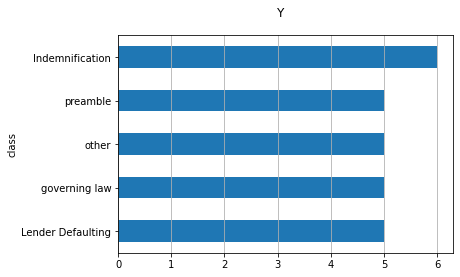

In [4]:
fig , ax = plt.subplots()
fig.suptitle("Y" , fontsize = 12)
train_df["class"].reset_index().groupby("class").count().sort_values(by="index").plot(kind = "barh",legend=False,ax=ax).grid(axis = 'x')
plt.show()

Text augumentation

In [5]:
pip install nlpaug

     |████████████████████████████████| 410 kB 10.3 MB/s 
     |████████████████████████████████| 11.3 MB 65.5 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.7.0 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.31.1 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


In [6]:
import nlpaug.augmenter.word as naw
aug_df = pd.read_csv('statement1.csv')
modified_aug_df = aug_df.copy()

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


In [8]:
# Using BERT for Text - Augumentation
TOPK=20 #default=100
ACT = 'insert' #"substitute"
aug_bert = naw.ContextualWordEmbsAug(
    model_path='distilbert-base-uncased', 
    device='cuda',
    action=ACT, top_k=TOPK)
# print("Original:")

for ind in aug_df.index:
    test_sentence = aug_df['statement'][ind]
    # print(ind)
    # print(test_sentence)
    for ii in range(4):
        augmented_text = aug_bert.augment(test_sentence)
        # temp = {'statement':augmented_text , 'class':aug_df['class'][ind]}
        # modified_aug_df.append(temp ,ignore_index = True )
        modified_aug_df.loc[len(modified_aug_df.index)] = [augmented_text , aug_df['class'][ind]]
        # print(augmented_text)
    # print()

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

In [9]:
modified_aug_df.shape

(130, 2)

## Text preprocessing

In [10]:
'''
    Pre-processing of Text -
        1. Cleaning Text
        2. Removing Stop Words
        3. Applying Lemmatization
    
    Preprocess a string.
        :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
'''

def utils_preprocess_text(text , flg_stemm=False,flg_lemm=True,lst_stopwords = None):

    # cleaning - convert to lowercase , removing punctuations and characters.
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    # Tokenize ( convert string to list ).
    lst_text = text.split()

    # Removing Stop - Words
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming ( Removing -ing, -ly .. )
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
        
    text = " ".join(lst_text)
    return text

In [11]:
# importing stop words from NLTK.
lst_stopwords = nltk.corpus.stopwords.words("english")

In [12]:
# Adding cleaned text as a column in training DataFrame.
train_df = modified_aug_df.copy()
train_df["text"] = train_df["statement"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
train_df.head()

,statement,class,text
0,This CREDIT AGREEMENT is entered into as of No...,preamble,credit agreement entered november 23 2010 amon...
1,This agreement is dated 22 December 2014 and m...,preamble,agreement dated 22 december 2014 made party xy...
2,This Agreement and shall be governed by and in...,governing law,agreement shall governed interpreted accordanc...
3,The choice of South African law as the governi...,governing law,choice south african law governing law finance...
4,This agreement and other loan documents shall ...,governing law,agreement loan document shall governed adheren...


In [13]:
# replacing target variables with a number
possible_class = train_df['class'].unique()
label_dict = {}
for index, possible_label in enumerate(possible_class):
    label_dict[possible_label] = index
label_dict

{'Indemnification': 3,
 'Lender Defaulting': 4,
 'governing law': 1,
 'other': 2,
 'preamble': 0}

In [14]:
train_df['labels'] = train_df['class'].replace(label_dict)
train_df.head()

,statement,class,text,labels
0,This CREDIT AGREEMENT is entered into as of No...,preamble,credit agreement entered november 23 2010 amon...,0
1,This agreement is dated 22 December 2014 and m...,preamble,agreement dated 22 december 2014 made party xy...,0
2,This Agreement and shall be governed by and in...,governing law,agreement shall governed interpreted accordanc...,1
3,The choice of South African law as the governi...,governing law,choice south african law governing law finance...,1
4,This agreement and other loan documents shall ...,governing law,agreement loan document shall governed adheren...,1


## Final Dataframe

In [15]:
# randomly shuffling of training data
train_df = train_df.sample(frac = 1)

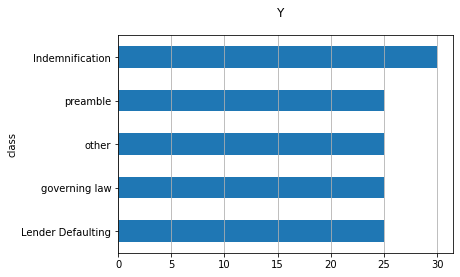

In [16]:
'''
  Univariate Distribution of the Target Variable by showing labels frequency with a Bar - Plot in the Augumented Dataset.
'''
fig , ax = plt.subplots()
fig.suptitle("Y" , fontsize = 12)
train_df["class"].reset_index().groupby("class").count().sort_values(by="index").plot(kind = "barh",legend=False,ax=ax).grid(axis = 'x')
plt.show()

In [17]:
# Removing OLD columns
train_df.drop(['class'] , axis = 1 , inplace = True)
train_df.drop(['statement'] , axis = 1 , inplace = True)

In [18]:
train_df.head()

,text,labels
116,lender obligation shall deemed either temporar...,4
31,agreement application dated 22 december 2014 m...,0
70,defaulting debt lender right approve immediate...,4
58,accordingly borrower shall indemnify whatsoeve...,3
126,borrower certain lender agent party willing co...,2


## Training and Test Dataset Creation

In [23]:
X = train_df.drop('labels' , axis= 1)
Y = train_df['labels']

In [24]:
Y = Y.to_frame()
#Y.set_index('labels')

In [26]:
# splitting of training and validation data
from sklearn.model_selection import train_test_split
X_train , X_test , Y_train , Y_test = train_test_split(X , Y , test_size=0.33,random_state = 42)

In [27]:
train_df_temp = X_train.copy()
train_df_temp['lables'] = Y_train
train_df_temp.head()

,text,lables
114,lender shall deemed deemed defaulting income l...,4
40,choice south central african law determining g...,1
2,agreement shall governed interpreted accordanc...,1
3,choice south african law governing law finance...,1
37,agreement covenant covenant shall shall govern...,1


## Model Creation

In [28]:
model_args = ClassificationArgs(num_train_epochs=5, overwrite_output_dir = True)

In [30]:
# Create a ClassificationModel
model = ClassificationModel(
    'bert',
    'bert-base-cased',
    num_labels=5,
    args=model_args,
    use_cuda=True,
) 
# Train the model
model.train_model(train_df_temp)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/87 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_5_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/11 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/11 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/11 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/11 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/11 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


(55, 0.7784738304940138)

In [31]:
# Make predictions with the model
predictions, raw_outputs = model.predict(["As soon as practicable after any payment of Indemnified Taxes or Other Taxes by an Obligor to a Governmental Authority, the Obligor shall deliver to the Administrative Agent the original or a certified copy of a receipt issued by such Governmental Authority evidencing such payment, a copy of the return reporting such payment or other evidence of such payment reasonably satisfactory to the Administrative Agent."])

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
prediction_dict = {3 : 'Indemnification', 4 : 'Lender Defaulting',1 : 'governing law',2 : 'other', 0 : 'preamble'}
prediction_dict[predictions[0]]

'Indemnification'

In [33]:
ls = []
for ind in X_test.index:    
    ls.append(X_test['text'][ind])
# ls
y_predict , y_predicted_prob = model.predict(ls)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_predict)
cm_df = pd.DataFrame(cm,
                     index = ['preamble','governing law','other', 'Indemnification', 'Lender Defaulting'], 
                     columns = ['preamble','governing law','other', 'Indemnification', 'Lender Defaulting'])

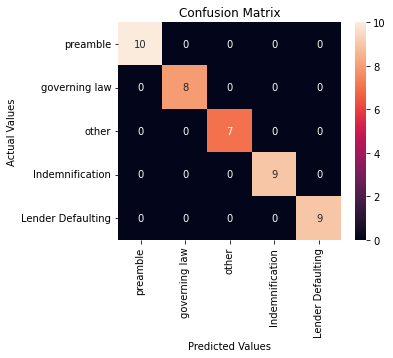

In [35]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [36]:
from sklearn.metrics import f1_score
f1_score(Y_test, y_predict, labels=None, pos_label=1, average='macro', sample_weight=None, zero_division='warn')

1.0

In [37]:
from sklearn.metrics import precision_score
precision_score(Y_test, y_predict, labels=None, pos_label=1, average='macro', sample_weight=None, zero_division='warn')

1.0

In [38]:
from sklearn.metrics import recall_score
recall_score(Y_test, y_predict, labels=None, pos_label=1, average='macro', sample_weight=None, zero_division='warn')

1.0

In [39]:
from sklearn.metrics import classification_report
print(classification_report(Y_test , y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



## Prediction on Test Dataset

In [41]:
test_df = pd.read_csv('test_data.csv')
test_df

,statement
0,"Amendment No. 1 dated as of February 4, 2016 (..."
1,"Subject to the Legal Reservations, (a) the cho..."
2,"This Agreement, and any non-contractual obliga..."
3,Each Lender agrees to indemnify the Administra...
4,Any Lender that (a) has failed to (i) fund all...
5,This Assignment and Assumption shall be govern...
6,As soon as practicable after any payment of In...
7,"Non-Defaulting Lender means, at any time, each..."
8,Fundco Facility Agreement means the facility a...
9,Notwithstanding any provision of this Agreemen...


In [42]:
# Preprocessing Test - Dataset
test_df["text"] = test_df["statement"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
test_df.head()

,statement,text
0,"Amendment No. 1 dated as of February 4, 2016 (...",amendment 1 dated february 4 2016 amendment 1 ...
1,"Subject to the Legal Reservations, (a) the cho...",subject legal reservation choice law specified...
2,"This Agreement, and any non-contractual obliga...",agreement noncontractual obligation arising co...
3,Each Lender agrees to indemnify the Administra...,lender agrees indemnify administrative agent h...
4,Any Lender that (a) has failed to (i) fund all...,lender failed fund portion loan within two bus...


In [43]:
test_df.drop(['statement'] , axis = 1 , inplace = True)

In [44]:
test_df.head()

,text
0,amendment 1 dated february 4 2016 amendment 1 ...
1,subject legal reservation choice law specified...
2,agreement noncontractual obligation arising co...
3,lender agrees indemnify administrative agent h...
4,lender failed fund portion loan within two bus...


In [45]:
ls = []
for ind in test_df.index:    
    ls.append(test_df['text'][ind])
# ls
y_predict ,y_confidence_score = model.predict(ls)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [46]:
y_confidence_score

array([[ 2.22645402, -0.32360169, -0.53270668, -0.7225706 , -1.07755184],
       [-0.63577455,  2.52232456, -0.15546873, -0.0529381 , -1.0011487 ],
       [-1.55797982,  2.05524015, -0.46588567,  0.80339295, -0.44466153],
       [-1.72330117, -0.34980065, -0.50606197,  2.4367702 ,  0.33445817],
       [-0.94321132, -0.21144062, -0.02994967,  1.57679105, -0.11698589],
       [-1.50307286,  1.53463018,  0.38915506,  0.39741066, -0.53901011],
       [-0.45227477,  1.04343212, -0.33321664,  1.61558068, -1.18029523],
       [-1.356552  , -0.9799909 , -0.48953584,  0.31169161,  2.05380058],
       [ 1.55072796, -0.18299897,  0.32603315, -0.74807006, -1.24760509],
       [-1.38373184, -0.83236641, -0.7444424 ,  0.07583554,  2.31883669]])

In [47]:
final_prediction = []
for i in range(len(y_predict)):
    final_prediction.append(prediction_dict[y_predict[i]])
final_prediction

['preamble',
 'governing law',
 'governing law',
 'Indemnification',
 'Indemnification',
 'governing law',
 'Indemnification',
 'Lender Defaulting',
 'preamble',
 'Lender Defaulting']

In [48]:
final_dict_ans = {}
for i in range(len(final_prediction)):
    final_dict_ans[ls[i]] = final_prediction[i]
final_dict_ans

{'agreement noncontractual obligation arising connection shall governed construed accordance english law': 'governing law',
 'amendment 1 dated february 4 2016 amendment 1 amendment restatement agreement dated january 10 2016 existing restatement agreement among ggg holding u inc borrower cgg societe anonyme incorporated law france parent lender time time party thereto suisse ag administrative agent lender capacity administrative agent collateral agent collateral agent lender': 'preamble',
 'assignment assumption shall governed construed accordance law governing credit agreement': 'governing law',
 'fundco facility agreement mean facility agreement dated date agreement made fundco initial lender defined fundco facility agreement including borrower devco': 'preamble',
 'lender agrees indemnify administrative agent hold harmless rateably according applicable percentage loss claim damage liability related expense including fee charge disbursement counsel may incurred asserted administrati

In [49]:
import json
json_object = json.dumps(final_dict_ans, indent = 4)
print(json_object)

{
    "amendment 1 dated february 4 2016 amendment 1 amendment restatement agreement dated january 10 2016 existing restatement agreement among ggg holding u inc borrower cgg societe anonyme incorporated law france parent lender time time party thereto suisse ag administrative agent lender capacity administrative agent collateral agent collateral agent lender": "preamble",
    "subject legal reservation choice law specified eachfinance document governing law finance document recognized enforced relevant jurisdiction andb judgment obtained new york jurisdiction governing law finance document relation finance document recognized enforced relevant jurisdiction": "governing law",
    "agreement noncontractual obligation arising connection shall governed construed accordance english law": "governing law",
    "lender agrees indemnify administrative agent hold harmless rateably according applicable percentage loss claim damage liability related expense including fee charge disbursement couns

In [50]:
jsonFile = open("final_output.json", "w")
jsonFile.write(json_object)
jsonFile.close()